In [2]:
# Plot of final semi-major axis, a_f as a function of the initial semi-major axis, a_i of the PBH-binary with
# dark matter halo's density profile of ρ(r)∝ r^{-9/4}. 



import numpy as  np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math



yr=3.154e7
π=np.pi
c=3e8                  #in units of m s^-1
t_eq=1.59246e12        # in units of seconds
ρ_eq=2.15368e-16       # in units of kg.m^-3
G=6.67e-11             # in units of m^3.kg^-1.s^-2          
a_eq=2.9374e-4         # scale factor corresponding to matter radiation equlaity
t_merge=13.78e9*yr     # in seconds
M_solar=1.989e30       # in units of kg



λ_list=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,
        1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,
        3.4,3.5,3.6,3.7,3.8,3.9,4.0]




    
def t(s):  
    return ((math.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s-2)*math.sqrt(s+1))+(4/3)))

def M_halo(M_PBH,s):  # Initial mass of the dark halo of PBH  with mass M_PBH.             
    return (((8*π)/3)*ρ_eq*(t_eq**(3/2))*(2**(5/4))*(G*M_PBH)*math.sqrt(t(s)))


def h(s):
    return math.sqrt((s**-3)+(s**-4))   
def g(s):
    return  -((3*s+4)/(2*h(s)*(s**5))) #g(x)=h'(x).

def f(s):
    return (1/(1+((M_halo(M_1PBH,s)+M_halo(M_2PBH,s))/(M_1PBH+M_2PBH))))
                   
def λ(s):
    return λ_0*f(s)
   

    
def s_dec(λ_0):   # Function to calculate the scale-factor of the PBH binary decouple from Hubble flow.
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]   
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=(As[i]*λ_0)             # As ss=s/λ_0.
        if Δ<0:
            break
        
    return s







def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        semi=(((A/2)*λ_0))                   #As Bs=separations/λ_0.
        if Δ<0:
            x=(((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))    # The initial comoving separation of the PBH binary in units of meter.
            a=(x*semi)
            break
        
    
    return a


def M_(M_PBH,s):   #Mass of PBH + Initial mass of it's dark matter halo having size r=r_ta.
    return (M_PBH + M_halo(M_PBH,s))
            
def j_i(λ_0,s):    # Initial angular momentum of the PBH binary.
    return  ((((85/3)*(G**3)*M_(M_1PBH,s)*M_(M_2PBH,s)*(M_(M_1PBH,s)+M_(M_2PBH,s))*t_merge)/((a(λ_0)**4)*(c**5)))**(1/7))


def e_i(λ_0):  # Initial eccentricity of the PBH binarys
    return ((1-(j_i(λ_0,s)**2))**(1/2))


def r_min(λ_0): #Distance of closest approach, r_min of the PBH binary orbit.
    return (a(λ_0)*(1-e_i(λ_0))) 



def r_ta(M_PBH,s): #r_turnaround of the dark matter halos, eq.(5) in "WIMPs and stellar-mass primordial black holes are incompatible"
    return ((2*G*M_PBH*(t(s)**2))**(1/3))


def ρ_bar(M_PBH):
    return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*M_PBH)**(3/4))) 
 
def E_b(M_PBH,λ_0,s):  # The binding energy, E_b of the dark matter halos calculated within r_min/2 and r_ta.
    return ((16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta(M_PBH,s))**(-1/4))-((r_min(λ_0)/2)**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2)*(((r_ta(M_PBH,s))**(1/2))-((r_min(λ_0)/2)**(1/2)))))



def M_halo_f(M_PBH,λ_0): #Final mass of the dark matter halos having size r=r_min/2.
    return (16/3)*π*ρ_bar(M_PBH)*((r_min(λ_0)/2)**(3/4))

def M_f(M_PBH,λ_0):   # Mass of M_PBH + final mass of it's dark matter halo having size r=r_min/2.
    return (M_PBH + M_halo_f(M_PBH,λ_0))

def a_f(λ_0,a_i,s): #Final semi-major axis of the PBH binary.
    return ((G*M_f(M_1PBH,λ_0)*M_f(M_2PBH,λ_0)*a_i)/((G*M_(M_1PBH,s)*M_(M_2PBH,s))-(2*a_i*(E_b(M_1PBH,λ_0,s)+E_b(M_2PBH,λ_0,s)))))


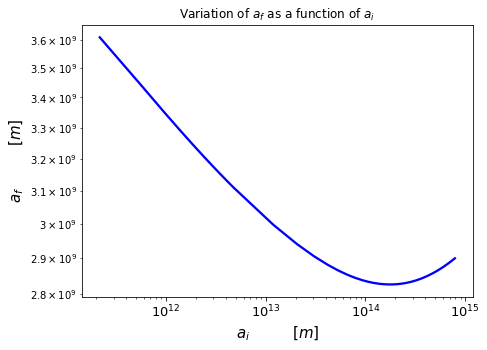

In [3]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=1e-3M☉ and M_2PBH= 1M☉.

M_1PBH=1e-3*M_solar     # in units of kg
M_2PBH=1*M_solar        # in units of kg


s_dec_list=np.zeros(len(λ_list))


for i, (λ_0) in enumerate (λ_list):
    s_dec_list[i]= s_dec(λ_0)
    
a_i_1_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_1_list[i] = a(λ_0)


a_f_1_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_1_list,s_dec_list)):
    a_f_1_list[i]=a_f(λ_0,a_i,s)
    


plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_1_list,a_f_1_list,'b')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

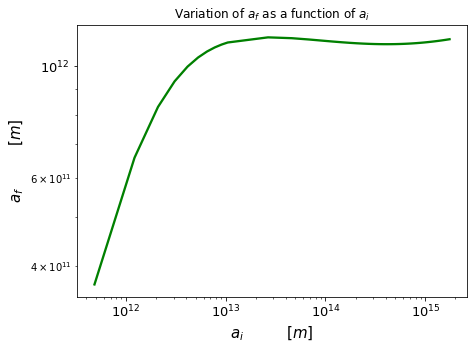

In [6]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=1M☉ and M_2PBH= 10M☉. 

M_1PBH=1*M_solar      # in units of kg
M_2PBH=10*M_solar     # in units of kg


s_dec_list=np.zeros(len(λ_list))
for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
    
a_i_2_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_2_list[i] = a(λ_0)

    
a_f_2_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_2_list,s_dec_list)):
    a_f_2_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_2_list,a_f_2_list,'g')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

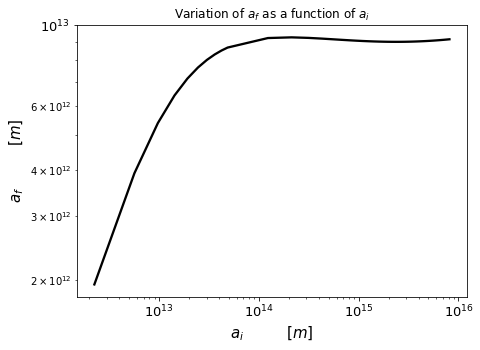

In [8]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=100M☉ and M_2PBH= 1000M☉. 

M_1PBH=100*M_solar     # in units of kg
M_2PBH=1000*M_solar    # in units of kg


s_dec_list=np.zeros(len(λ_list))
for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
    
a_i_3_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_3_list[i] = a(λ_0)

    
a_f_3_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_3_list,s_dec_list)):
    a_f_3_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_3_list,a_f_3_list,'k')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

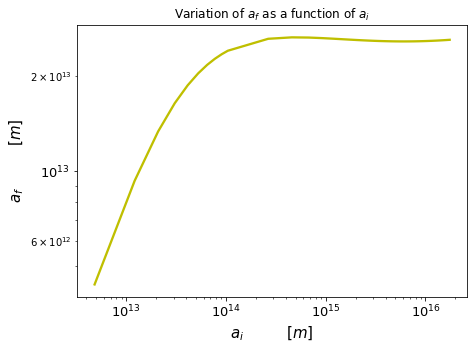

In [10]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=1000M☉ and M_2PBH= 1e4M☉. 

M_1PBH=1000*M_solar     # in units of kg
M_2PBH=1e4*M_solar      # in units of kg


s_dec_list=np.zeros(len(λ_list))
for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
    
a_i_4_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_4_list[i] = a(λ_0)

    
a_f_4_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_4_list,s_dec_list)):
    a_f_4_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_4_list,a_f_4_list,'y')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

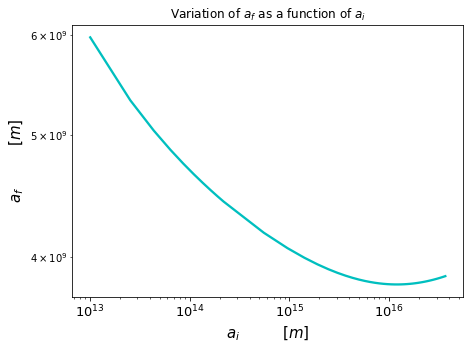

In [12]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=10M☉ and M_2PBH= 1e5M☉. 

M_1PBH=1*M_solar       # in units of kg
M_2PBH=1e5*M_solar      # in units of kg


s_dec_list=np.zeros(len(λ_list))
for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
    
a_i_5_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_5_list[i] = a(λ_0)

    
a_f_5_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_5_list,s_dec_list)):
    a_f_5_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_5_list,a_f_5_list,'c')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

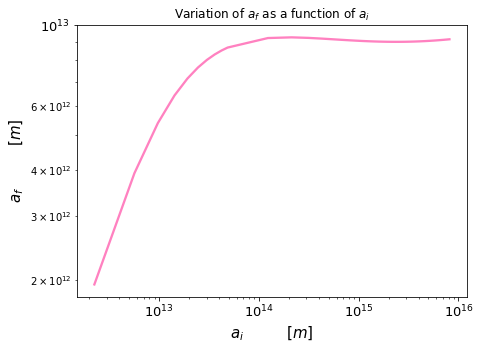

In [13]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=10M☉ and M_2PBH= 1000M☉. 

M_1PBH=100*M_solar       # in units of kg
M_2PBH=1000*M_solar      # in units of kg


s_dec_list=np.zeros(len(λ_list))
for i, (λ_0,s) in enumerate(zip(λ_list,s_list)):
    s_dec_list[i]= s_dec(λ_0)
    
    
a_i_6_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_6_list[i] = a(λ_0)

    
a_f_6_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_6_list,s_dec_list)):
    a_f_6_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_6_list,a_f_6_list,'#FF81C0')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

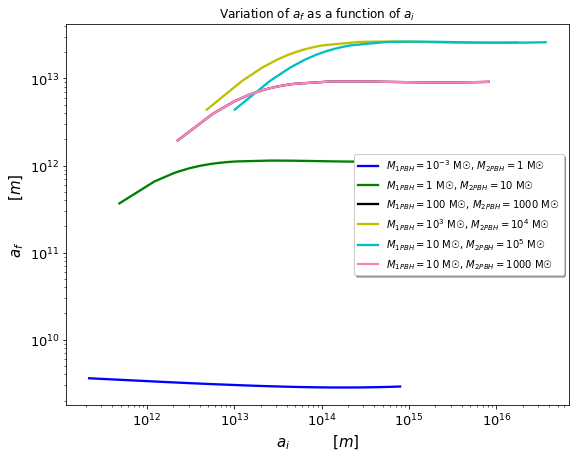

In [25]:
plt.figure(figsize=(9,7))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_1_list,a_f_1_list,'b')
plt.loglog(a_i_2_list,a_f_2_list,'g')
plt.loglog(a_i_3_list,a_f_3_list,'k')
plt.loglog(a_i_4_list,a_f_4_list,'y')
plt.loglog(a_i_5_list,a_f_4_list,'c')
plt.loglog(a_i_6_list,a_f_6_list,'#FF81C0')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.legend(["$M_{1PBH}=10^{-3}$ M☉, $M_{2PBH}=1$ M☉","$M_{1PBH}=1$ M☉, $M_{2PBH}=10$ M☉","$M_{1PBH}=100$ M☉, $M_{2PBH}=1000$ M☉","$M_{1PBH}=10^{3}$ M☉, $M_{2PBH}=10^{4}$ M☉",
            "$M_{1PBH}=10$ M☉, $M_{2PBH}=10^{5}$ M☉","$M_{1PBH}=10$ M☉, $M_{2PBH}=1000$ M☉"], prop = {'size':10},loc='center right',shadow = True, facecolor = 'white',fontsize=19)

plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

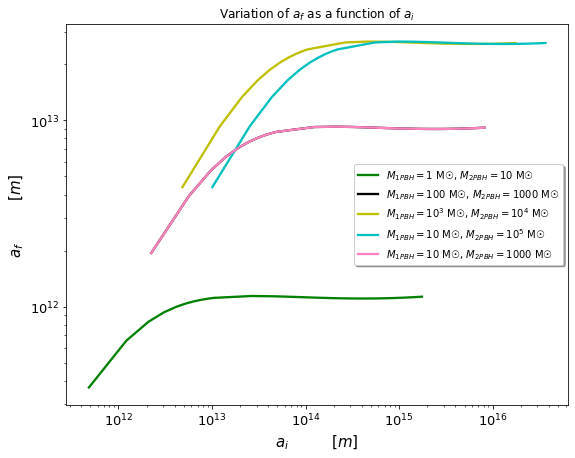

In [26]:
plt.figure(figsize=(9,7))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_2_list,a_f_2_list,'g')
plt.loglog(a_i_3_list,a_f_3_list,'k')
plt.loglog(a_i_4_list,a_f_4_list,'y')
plt.loglog(a_i_5_list,a_f_4_list,'c')
plt.loglog(a_i_6_list,a_f_6_list,'#FF81C0')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.legend(["$M_{1PBH}=1$ M☉, $M_{2PBH}=10$ M☉","$M_{1PBH}=100$ M☉, $M_{2PBH}=1000$ M☉","$M_{1PBH}=10^{3}$ M☉, $M_{2PBH}=10^{4}$ M☉",
            "$M_{1PBH}=10$ M☉, $M_{2PBH}=10^{5}$ M☉","$M_{1PBH}=10$ M☉, $M_{2PBH}=1000$ M☉"], prop = {'size':10},loc='center right',shadow = True, facecolor = 'white',fontsize=19)

plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.savefig('a_f vs a_i.pdf')
plt.show()